In [38]:
import matplotlib.pyplot as plt
import numpy as np
import ase.io as io
import json
import pandas as pd

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True
})

- "opt": optimsation loss, training set loss
    - computed for every batch, including pretraining data
    - the average is technically at half an epoch
- "eval": evaluation loss, validation set loss
    - data for every epoch
    - first value is pt_head and 2nd is default

- Validation loss for the pt head increases as the model is finetuned away from the pretraining dataset with the default head

- training loss on materials project dataset, avg ~5000 samples
- small model may struggle with mptraj dataset

In [6]:
def plot_loss_single(results_path):

    data = []

    with open(results_path, "r") as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping invalid line: {line}")

    df = pd.DataFrame(data)

    # epoch (for validation)
    eval_df = df[df["mode"] == "eval"].dropna(subset=["epoch"]) # first two epoch values are NaN (initial values )
    eval_pt_df = eval_df.iloc[::2]
    eval_default_df = eval_df.iloc[1::2]

    # batch (for training)
    opt_df = df[df["mode"] == "opt"]
    opt_df_avg = opt_df.groupby("epoch")["loss"].mean() # avg over all batches for each epoch
    opt_df_sd = opt_df.groupby("epoch")["loss"].std()

    plt.plot(eval_default_df["epoch"], eval_default_df["loss"], marker="o", label="Validation Loss")
    plt.plot(eval_pt_df["epoch"], eval_pt_df["loss"], marker="o", label="Validation Loss (PT)")
    plt.plot(opt_df_avg.index, opt_df_avg, marker="o", label="Training Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.yscale("log")
    plt.show()

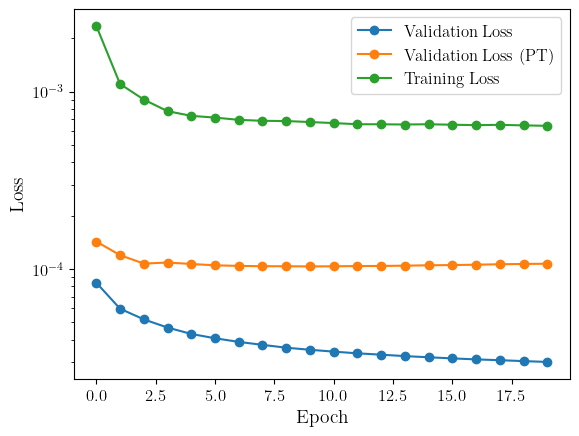

In [7]:
plot_loss_single("training_results_small/MACE_revPBE_D3_200_run-3_train.txt")

In [34]:
import re

def plot_loss_many(results_paths, FT=False, multihead_scratch = False, ylims=(0.00002, 0.005), filepath = None):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey='row')
    axes = axes.flatten()
    
    for i, results_path in enumerate(results_paths):
        data = []
        with open(results_path, "r") as f:
            for line in f:
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Skipping invalid line in {results_path}: {line}")

        df = pd.DataFrame(data)

        # Extract validation (eval) and training (opt) loss
        eval_df = df[df["mode"] == "eval"].dropna(subset=["epoch"])
        opt_df = df[df["mode"] == "opt"]
        opt_df_avg = opt_df.groupby("epoch")["loss"].mean()
        
        if FT == True:
            eval_pt_df = eval_df.iloc[::2]
            eval_default_df = eval_df.iloc[1::2]

            ax = axes[i]
            ax.plot(opt_df_avg.index, opt_df_avg, marker="o", label="Training Loss")
            ax.plot(eval_default_df["epoch"], eval_default_df["loss"], marker="o", label="Validation Loss")
            ax.plot(eval_pt_df["epoch"], eval_pt_df["loss"], marker="o", label="Validation Loss (PT)")
            
        elif FT == False:
            ax = axes[i]
            if multihead_scratch == False:
                ax.plot(opt_df_avg.index, opt_df_avg, marker="o", label="Training Loss")
                ax.plot(eval_df["epoch"], eval_df["loss"], marker="o", label="Validation Loss")
                if i == 2:
                    ax.plot([], [], marker="o", linestyle="-", label="Validation Loss (PT)")


                
            
            else:
                revPBE_df_eval = df[df["mode"] == "eval"].dropna(subset=["epoch"]).iloc[:-3:3]
                revPBE0_df_eval = df[df["mode"] == "eval"].dropna(subset=["epoch"]).iloc[1:-3:3]
                MP2_df_eval = df[df["mode"] == "eval"].dropna(subset=["epoch"]).iloc[2:-3:3]
                
                revPBE_opt_df = df[df["mode"] == "opt"].iloc[::3]
                revPBE_opt_df_avg = revPBE_opt_df.groupby("epoch")["loss"].mean()
                revPBE0_opt_df = df[df["mode"] == "opt"].iloc[1::3]
                revPBE0_opt_df_avg = revPBE0_opt_df.groupby("epoch")["loss"].mean()
                MP2_opt_df = df[df["mode"] == "opt"].iloc[2::3]
                MP2_opt_df_avg = MP2_opt_df.groupby("epoch")["loss"].mean()
                
                ax.plot(revPBE_df_eval["epoch"], revPBE_df_eval["loss"], marker="o", label="Validation Loss: revPBE-D3")
                ax.plot(revPBE0_df_eval["epoch"], revPBE0_df_eval["loss"], marker="o", label="Validation Loss: revPBE0-D3")
                ax.plot(MP2_df_eval["epoch"], MP2_df_eval["loss"], marker="o", label="Validation Loss: MP2")

                ax.plot(revPBE_opt_df_avg.index, revPBE_opt_df_avg, marker="o", label="Training Loss: revPBE-D3")
                ax.plot(revPBE0_opt_df_avg.index, revPBE0_opt_df_avg, marker="o", label="Training Loss: revPBE0-D3")
                ax.plot(MP2_opt_df_avg.index, MP2_opt_df_avg, marker="o", label="Training Loss: MP2")


        ax.set_xlabel("Epoch", fontsize=22)
        if i == 0 or i == 3:
            ax.set_ylabel("Loss", fontsize=22)
        ax.set_yscale("log") 
        ax.set_ylim(ylims)
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.tick_params(axis='both', labelsize=18)
        if i == 2: 
            ax.legend(loc="upper right", fontsize=18)
        
        number_match = re.search(r"D3_(\d+)_run", results_path)
        number = number_match.group(1) if number_match else "Unknown"
        ax.set_title(f"Training set size = {number}", fontsize=22)

    
    plt.tight_layout()
    if filepath:
        plt.savefig(f"../figures/{filepath}")
    plt.show()

In [160]:
results_paths_medium_newE0_revPBE = [
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_10_run-3_train.txt",
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_30_run-3_train.txt",
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_50_run-3_train.txt",
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_100_run-3_train.txt",
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_200_run-3_train.txt",
    "training_results_medium/MACE_medium_newE0s_revPBE_D3_300_run-3_train.txt"

]

- PT head loss flat --> model not forgetting
- why does loss not decrease too much for default head training


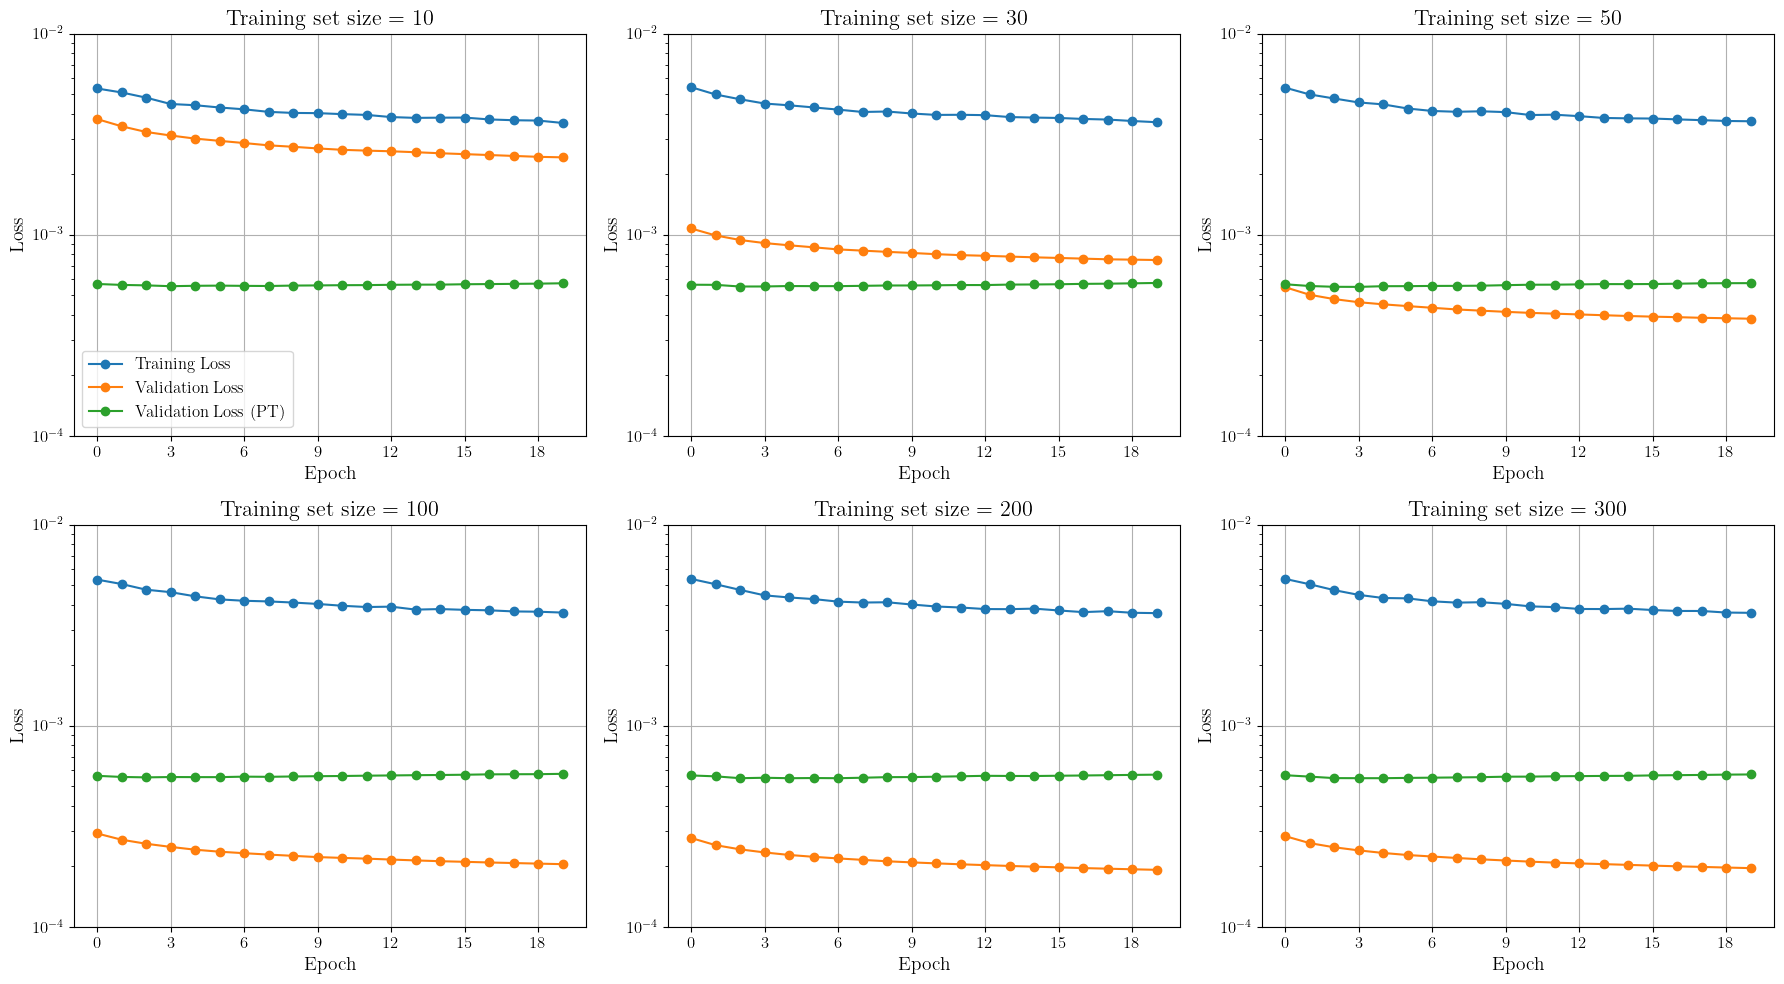

In [198]:
plot_loss_many(results_paths_medium_newE0_revPBE, FT=True, ylims=(0.0001, 0.01))

In [7]:
results_paths_mix = [
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_30_run-3_train.txt",
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_50_run-3_train.txt",
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_100_run-3_train.txt",
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_30_run-123_train.txt",
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_50_run-123_train.txt",
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_100_run-123_train.txt"
]

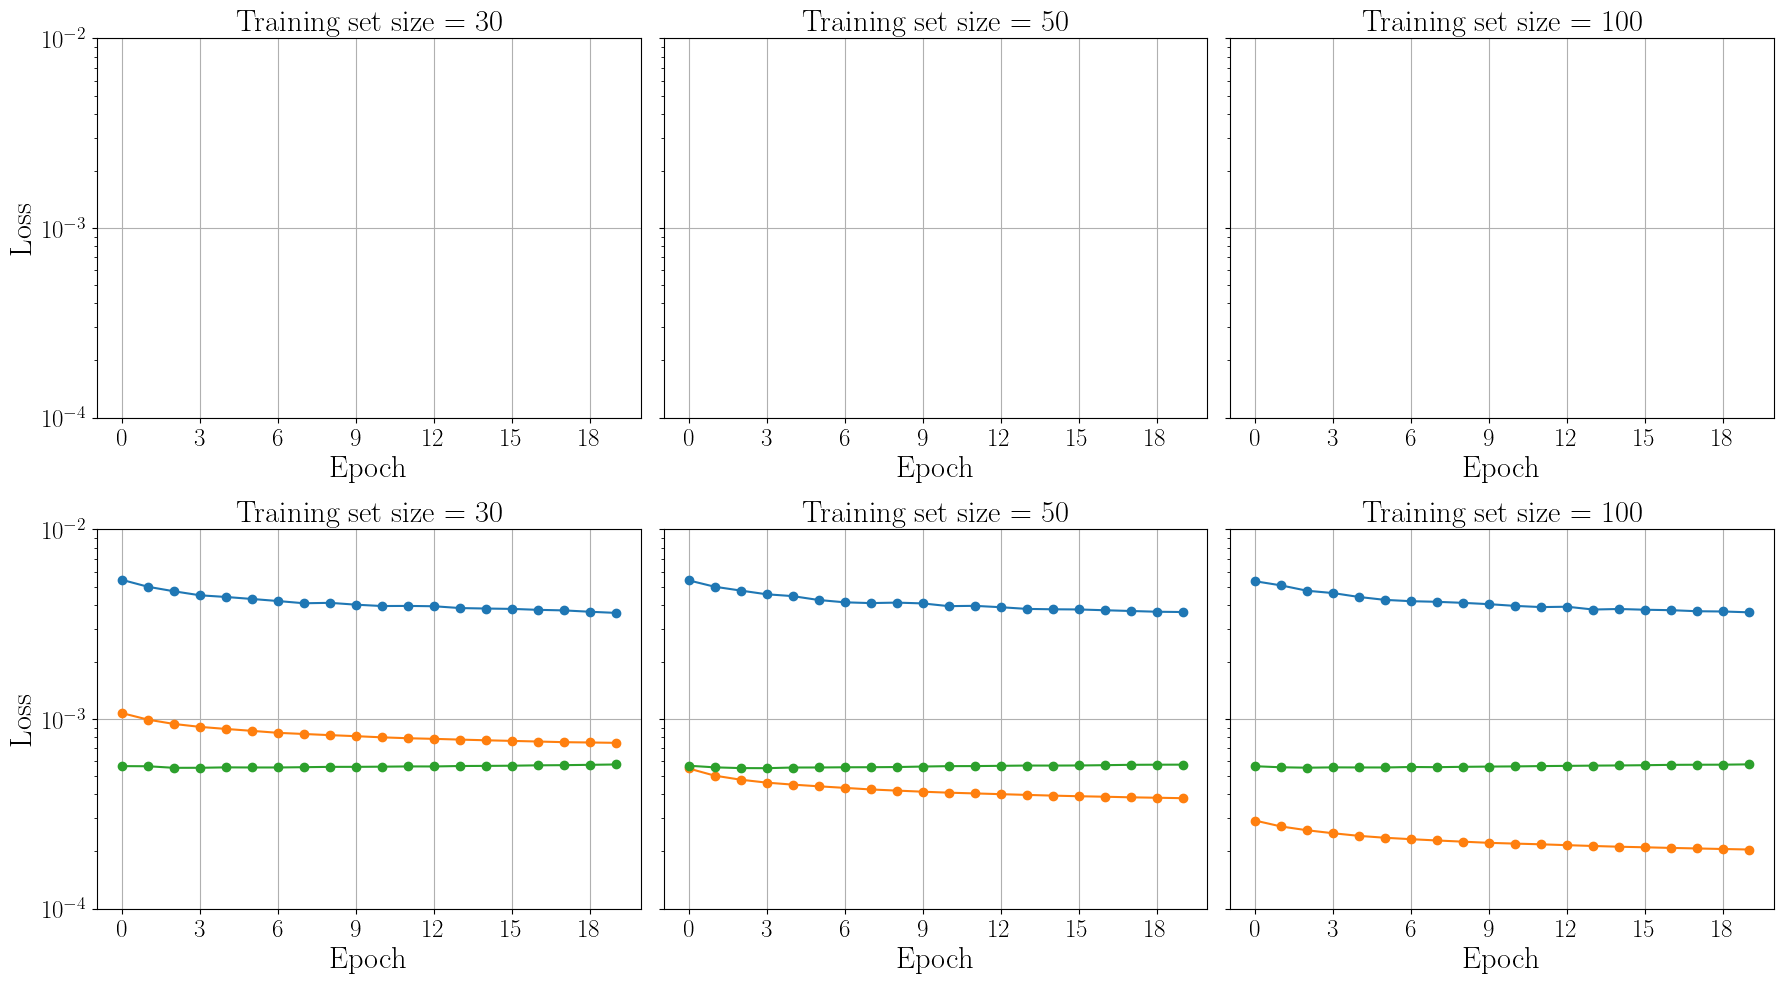

In [23]:
plot_loss_many(results_paths_mix, FT=True, ylims=(0.0001, 0.01), filepath="loss_many_FT.pdf")

In [30]:
results_paths_mix = [
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_30_run-123_train.txt",
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_50_run-123_train.txt",
    "../results/training_results_scratch/MACE_model_scratch_newE0s_revPBE_D3_100_run-123_train.txt",
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_30_run-3_train.txt",
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_50_run-3_train.txt",
    "../results/training_results_medium/MACE_medium_newE0s_revPBE_D3_100_run-3_train.txt",
]

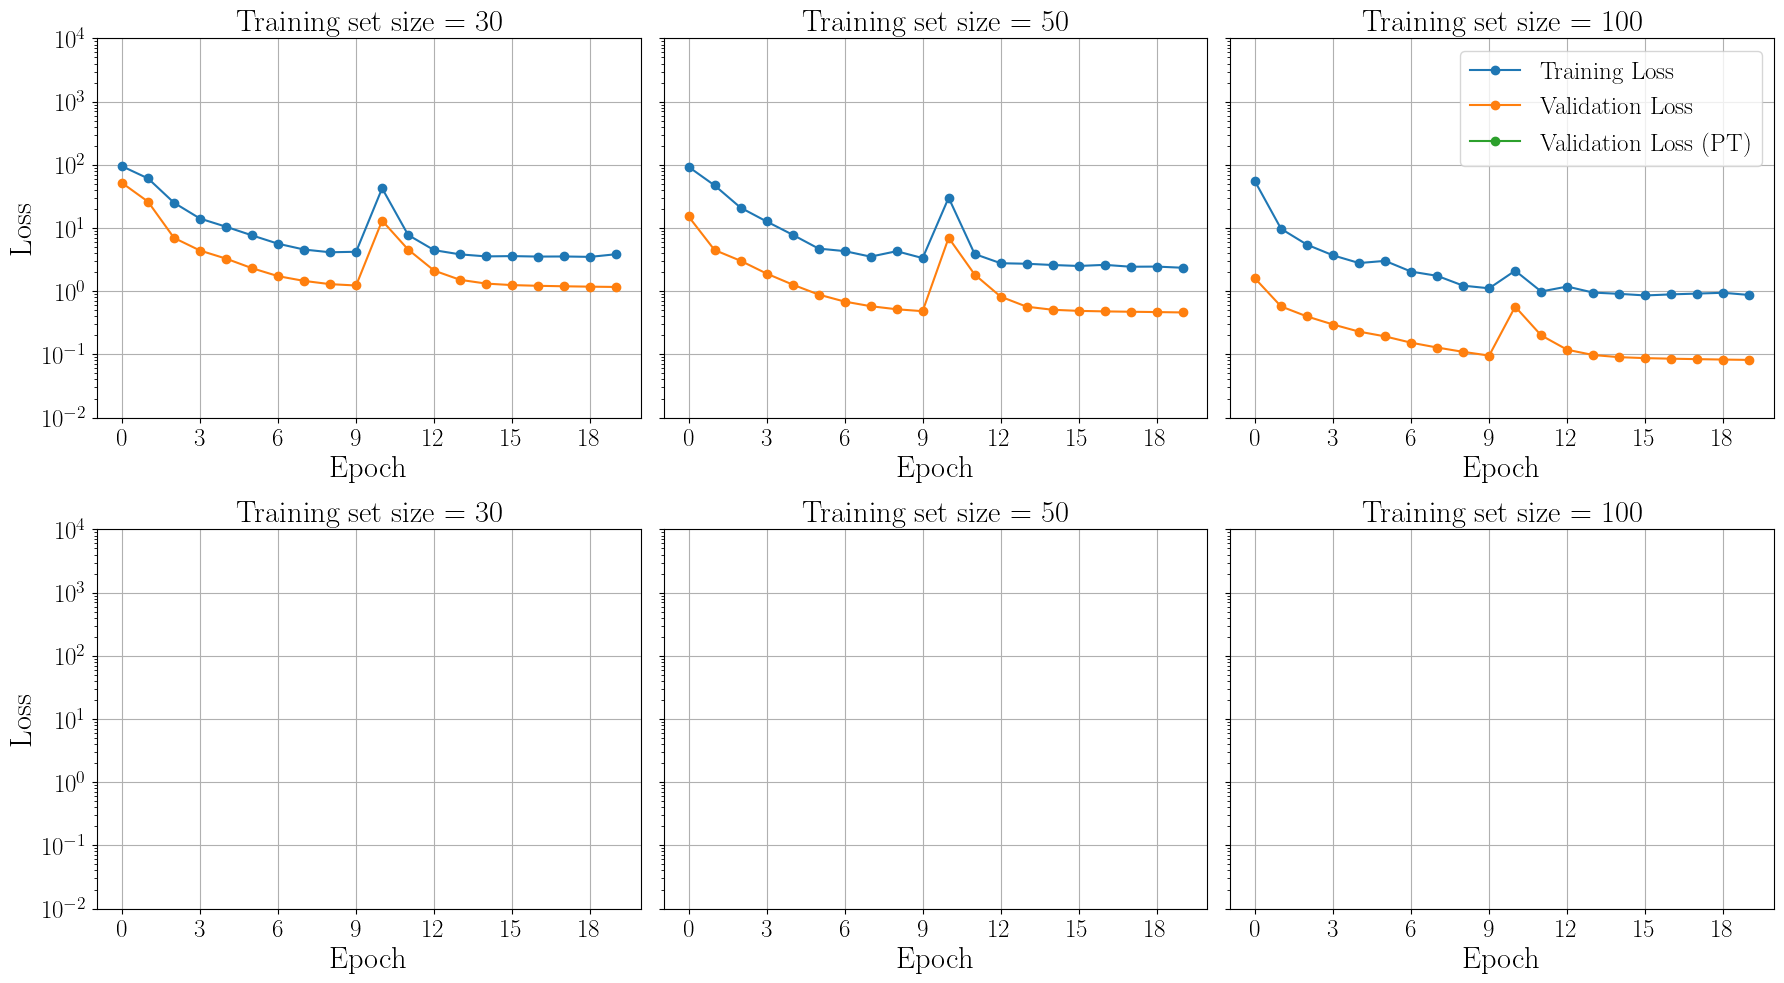

In [35]:
plot_loss_many(results_paths_mix, FT=False, ylims=(0.01, 10000), filepath="loss_many_scratch.pdf")

In [187]:
results_paths_scratch_multihead = [
    "training_results_multi/MACE_model_scratch_10_multihead_run-123_train.txt",
    "training_results_multi/MACE_model_scratch_30_multihead_run-123_train.txt",
    "training_results_multi/MACE_model_scratch_50_multihead_run-123_train.txt",
    "training_results_multi/MACE_model_scratch_100_multihead_run-123_train.txt",
    "training_results_multi/MACE_model_scratch_200_multihead_run-123_train.txt",
    "training_results_multi/MACE_model_scratch_300_multihead_run-123_train.txt",


]

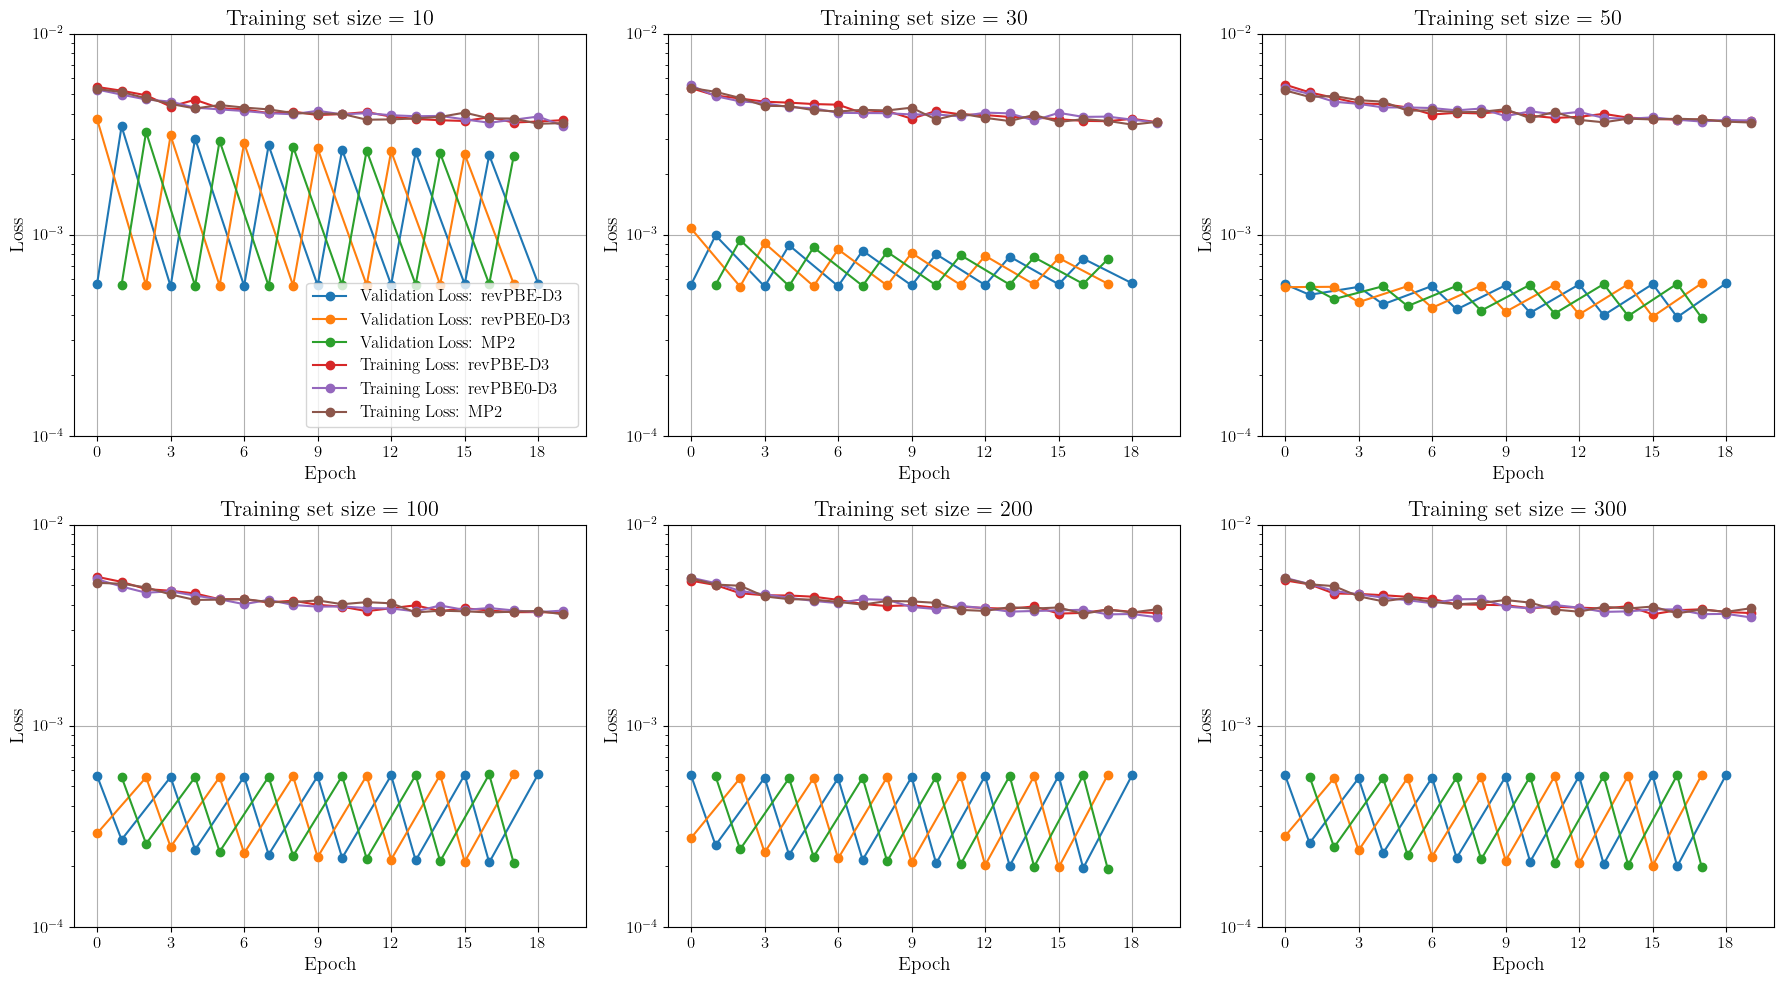

In [188]:
plot_loss_many(results_paths_medium_newE0_revPBE, multihead_scratch = True, ylims=(0.0001, 0.01))

### Evaluation of model on training and test data

In [2]:
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(configs, model, output):
    sys.argv = ["program", "--configs", configs, "--model", model, "--output", output]
    mace_eval_configs_main()

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


In [ ]:
eval_mace(configs="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/training_val_sets/training_set_20_revPBE_D3.xyz",
          model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/FT_models/MACE_revPBE_D3_20.model",
          output="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/tests/revPBE_D3/train_20.xyz")

print("evaluating test set....")
eval_mace(configs="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/training_val_sets/validation_set_100_revPBE_D3.xyz",
          model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/FT_models/MACE_revPBE_D3_20.model",
          output="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/tests/revPBE_D3/test_20.xyz")

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)


evaluating test set....


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)


In [60]:
# adapted from google colab tutorial

from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea
import numpy as np

def plot_RMSEs(db, labs, theory, filepath = None):
    # theory = "rPBED3", "rPBE0D3", "MP2"
    
    #ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') #Backward compatibility
    #ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace') #Backward compatibility
    ea.rename_prop_tag(db, f'{theory}_energy', 'energy_ref') 
    ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') 
    ea.rename_prop_tag(db, f'{theory}_forces', 'forces_ref') 
    ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace')


    plt.figure(figsize=(7,5), dpi=100)
    #plt.subplot(1,3,1)
    # pp.plot_prop(ea.get_prop(db, 'bind', '', True).flatten(), \
    #              ea.get_prop(db, 'bind', '_mace', True).flatten(), \
    #              title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,2,1)
    pp.plot_prop(ea.get_prop(db, 'info', 'energy_ref', True).flatten() * 1.6e-19 * 6.02e23 / 1000, \
                 ea.get_prop(db, 'info', 'energy_mace', True).flatten() * 1.6e-19 * 6.02e23 / 1000, \
                 title=r'Energy $(\rm KJ/mol)$ ', labs=labs, rel=False)
    plt.subplot(1,2,2)
    pp.plot_prop(np.concatenate(ea.get_prop(db, 'arrays', 'forces_ref')).flatten() * 1000, \
                 np.concatenate(ea.get_prop(db, 'arrays', 'forces_mace')).flatten() * 1000, \
                 title=r'Forces $\rm (meV/\AA)$ ', labs=labs, rel=False)
    plt.tight_layout()
    if filepath:
        plt.savefig(f"../figures/{filepath}", dpi=1000)
    plt.show()

    return


def calc_RMSE(db, theory):
    ea.rename_prop_tag(db, f'{theory}_energy', 'energy_ref') 
    ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') 
    ea.rename_prop_tag(db, f'{theory}_forces', 'forces_ref') 
    ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace')
    
    
    # rmse = np.sqrt(np.mean((prop1-prop2)**2))
    rmse_energy = np.sqrt(np.mean((ea.get_prop(db, 'info', 'energy_ref', True).flatten() - ea.get_prop(db, 'info', 'energy_mace', True).flatten())**2))
    rmse_forces = np.sqrt(np.mean((np.concatenate(ea.get_prop(db, 'arrays', 'forces_ref')).flatten() - np.concatenate(ea.get_prop(db, 'arrays', 'forces_mace')).flatten())**2))

    return rmse_energy, rmse_forces

0.0017 eV / atom -> 0.0017 * e * Na / 1000 = 0.16 KJ/mol

In [184]:
training_set_sizes_small = [10, 30, 50, 100, 200, 300]
RMSE_energies_small = []
RMSE_forces_small = []

for size in training_set_sizes_small:
    test_data = read(f"evaluation_data_small/FT_rev_PBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_small.append(calc[0])
    RMSE_forces_small.append(calc[1])
    
training_set_sizes_medium = [10, 50, 100]
RMSE_energies_medium = []
RMSE_forces_medium = []

for size in training_set_sizes_medium:
    test_data = read(f"evaluation_data_medium/FT_rev_PBE_D3_{size}_eval_test_medium.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_medium.append(calc[0])
    RMSE_forces_medium.append(calc[1])
    
training_set_sizes_medium_pt1000 = [10, 30, 50, 100, 200, 300]
RMSE_energies_medium_pt1000 = []
RMSE_forces_medium_pt1000 = []

for size in training_set_sizes_medium_pt1000:
    test_data = read(f"evaluation_data_medium/FT_pt1000_medium_rev_PBE_D3_{size}_eval_test_medium.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_medium_pt1000.append(calc[0])
    RMSE_forces_medium_pt1000.append(calc[1])
    

training_set_sizes_medium_rerun = [10, 50, 100, 200, 300]
RMSE_energies_medium_rerun = []
RMSE_forces_medium_rerun = []

for size in training_set_sizes_medium_rerun:
    test_data = read(f"evaluation_data_medium/FT_rerun_medium_rev_PBE_D3_{size}_eval_test_medium.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_medium_rerun.append(calc[0])
    RMSE_forces_medium_rerun.append(calc[1])
    

training_set_sizes_scratch_200epoch = [10, 30, 50, 100]
RMSE_energies_scratch_200epoch = []
RMSE_forces_scratch_200epoch = []

for size in training_set_sizes_scratch_200epoch:
    test_data = read(f"evaluation_data_scratch/scratch_rev_PBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_scratch_200epoch.append(calc[0])
    RMSE_forces_scratch_200epoch.append(calc[1])
    
training_set_sizes_scratch_20epoch = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_20epoch = []
RMSE_forces_scratch_20epoch = []

for size in training_set_sizes_scratch_20epoch:
    test_data = read(f"evaluation_data_scratch/scratch_20epoch_rev_PBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_scratch_20epoch.append(calc[0])
    RMSE_forces_scratch_20epoch.append(calc[1])

### Before correcting E0s
- unit conversion was also wrong for this plot

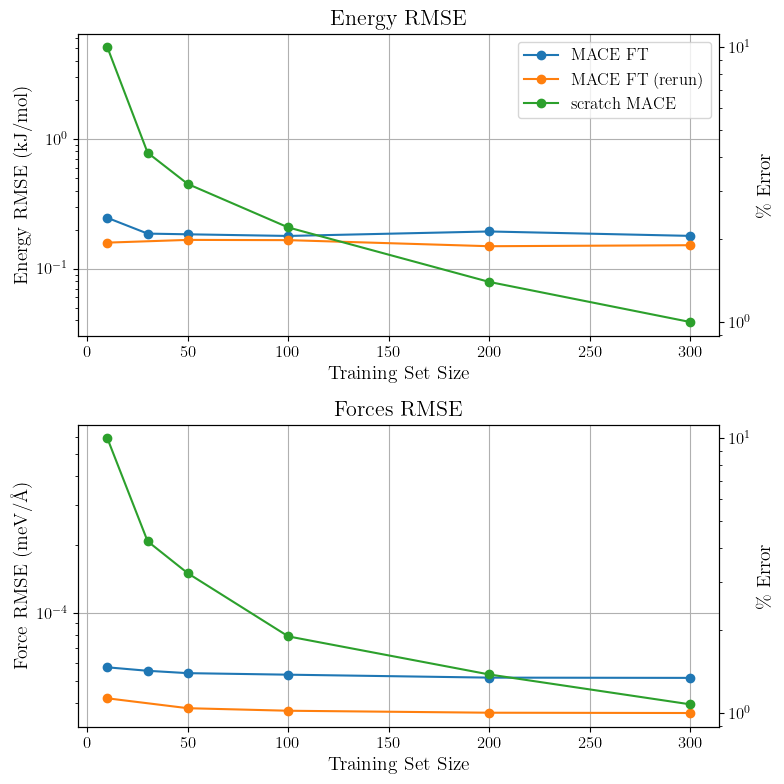

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(8, 8)) 


relative_RMSE_energies = np.array(RMSE_energies_small) / np.std(RMSE_energies_small) * 100
relative_RMSE_forces = np.array(RMSE_forces_small) / np.std(RMSE_forces_small) * 100


ax1 = axes[0]
ax1.plot(training_set_sizes_small, np.array(RMSE_energies_small) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT")
ax1.plot(training_set_sizes_medium_rerun, np.array(RMSE_energies_medium_rerun) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (rerun)")
#ax1.plot(training_set_sizes_medium, np.array(RMSE_energies_medium) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="medium MACE (fine-tuned)")
#ax1.plot(training_set_sizes_medium_pt1000, np.array(RMSE_energies_medium_pt1000) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE (fine-tuned) pt1000")
ax1.plot(training_set_sizes_scratch_20epoch, np.array(RMSE_energies_scratch_20epoch) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="scratch MACE")
ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")

# Add second y-axis for relative RMSE
ax1b = ax1.twinx()
ax1b.set_ylabel(r"$\%$ Error")
ax1b.set_yscale("log") 

# Plot Forces RMSE (Primary y-axis)
ax2 = axes[1]
ax2.plot(training_set_sizes_small, np.array(RMSE_forces_small) / 1000, marker="o")
ax2.plot(training_set_sizes_medium_rerun, np.array(RMSE_forces_medium_rerun) / 1000, marker="o")
#ax2.plot(training_set_sizes_medium, np.array(RMSE_forces_medium) / 1000, marker="o")
#ax2.plot(training_set_sizes_medium_pt1000, np.array(RMSE_forces_medium_pt1000) / 1000, marker="o")
ax2.plot(training_set_sizes_scratch_20epoch, np.array(RMSE_forces_scratch_20epoch) / 1000, marker="o")
ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)


ax2b = ax2.twinx()
ax2b.set_ylabel(r"$\%$ Error")
ax2b.set_yscale("log")

plt.tight_layout()
plt.show()


In [253]:
training_set_sizes_medium_revPBE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_medium_revPBE0 = []
RMSE_forces_medium_revPBE0 = []

for size in training_set_sizes_medium_revPBE0:
    test_data = read(f"evaluation_FT_revPBE0/FT_medium_rev_PBE0_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBE0D3")
    RMSE_energies_medium_revPBE0.append(calc[0])
    RMSE_forces_medium_revPBE0.append(calc[1])
    
    
training_set_sizes_medium_MP2 = [10, 30, 50, 100, 200, 300]
RMSE_energies_medium_MP2 = []
RMSE_forces_medium_MP2 = []

for size in training_set_sizes_medium_MP2:
    test_data = read(f"evaluation_FT_MP2/FT_medium_MP2_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="MP2")
    RMSE_energies_medium_MP2.append(calc[0])
    RMSE_forces_medium_MP2.append(calc[1])
    

training_set_sizes_scratch_20epoch_revPBE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_20epoch_revPBE0 = []
RMSE_forces_scratch_20epoch_revPBE0 = []

for size in training_set_sizes_scratch_20epoch_revPBE0: 
    test_data = read(f"evaluation_scratch_revPBE0/scratch_20epoch_revPBE0_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBE0D3")
    RMSE_energies_scratch_20epoch_revPBE0.append(calc[0])
    RMSE_forces_scratch_20epoch_revPBE0.append(calc[1])
    

training_set_sizes_scratch_20epoch_MP2 = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_20epoch_MP2 = []
RMSE_forces_scratch_20epoch_MP2 = []

for size in training_set_sizes_scratch_20epoch_revPBE0: 
    test_data = read(f"evaluation_scratch_MP2/scratch_20epoch_MP2_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="MP2")
    RMSE_energies_scratch_20epoch_MP2.append(calc[0])
    RMSE_forces_scratch_20epoch_MP2.append(calc[1])

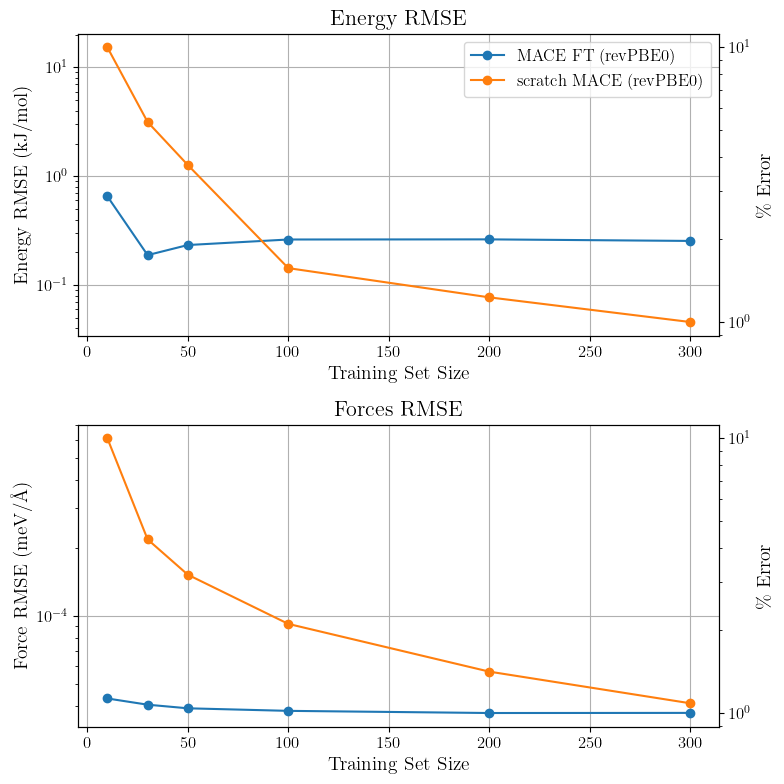

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

relative_RMSE_energies = np.array(RMSE_energies_small) / np.std(RMSE_energies_small) * 100 
relative_RMSE_forces = np.array(RMSE_forces_small) / np.std(RMSE_forces_small) * 100 

ax1 = axes[0]
ax1.plot(training_set_sizes_medium_revPBE0, np.array(RMSE_energies_medium_revPBE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (revPBE0)")
ax1.plot(training_set_sizes_scratch_20epoch_revPBE0, np.array(RMSE_energies_scratch_20epoch_revPBE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="scratch MACE (revPBE0)")
ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")

ax1b = ax1.twinx()
ax1b.set_ylabel(r"$\%$ Error")
ax1b.set_yscale("log") 

ax2 = axes[1]
ax2.plot(training_set_sizes_medium_revPBE0, np.array(RMSE_forces_medium_revPBE0) / 1000, marker="o")
ax2.plot(training_set_sizes_scratch_20epoch_revPBE0, np.array(RMSE_forces_scratch_20epoch_revPBE0) / 1000, marker="o")
ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)


ax2b = ax2.twinx()
ax2b.set_ylabel(r"$\%$ Error")
ax2b.set_yscale("log")

plt.tight_layout()
plt.show()


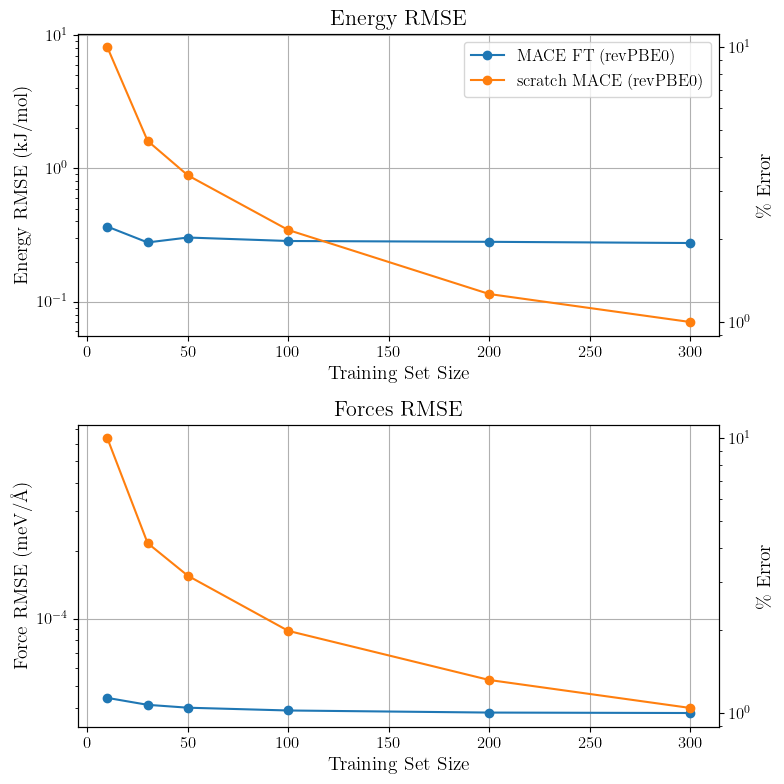

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

relative_RMSE_energies = np.array(RMSE_energies_small) / np.std(RMSE_energies_small) * 100
relative_RMSE_forces = np.array(RMSE_forces_small) / np.std(RMSE_forces_small) * 100

ax1 = axes[0]
ax1.plot(training_set_sizes_medium_MP2, np.array(RMSE_energies_medium_MP2) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (revPBE0)")
ax1.plot(training_set_sizes_scratch_20epoch_MP2, np.array(RMSE_energies_scratch_20epoch_MP2) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="scratch MACE (revPBE0)")
ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")

ax1b = ax1.twinx()
ax1b.set_ylabel(r"$\%$ Error")
ax1b.set_yscale("log") 

ax2 = axes[1]
ax2.plot(training_set_sizes_medium_MP2, np.array(RMSE_forces_medium_MP2) / 1000, marker="o")
ax2.plot(training_set_sizes_scratch_20epoch_MP2, np.array(RMSE_forces_scratch_20epoch_MP2) / 1000, marker="o")
ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)


ax2b = ax2.twinx()
ax2b.set_ylabel(r"$\%$ Error")
ax2b.set_yscale("log")

plt.tight_layout()
plt.show()

### revPBE-D3: New E0s

In [40]:
from ase.io import read

In [45]:
training_set_sizes_medium_revPBE_newE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_medium_revPBE_newE0 = []
RMSE_forces_medium_revPBE_newE0 = []

for size in training_set_sizes_medium_revPBE_newE0:
    test_data = read(f"../results/evaluation_data_medium/FT_newE0s_medium_rev_PBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_medium_revPBE_newE0.append(calc[0])
    RMSE_forces_medium_revPBE_newE0.append(calc[1])
    

training_set_sizes_medium_revPBE_naive = [10, 30, 50, 100, 200, 300]
RMSE_energies_medium_revPBE_naive = []
RMSE_forces_medium_revPBE_naive = []

for size in training_set_sizes_medium_revPBE_naive:
    test_data = read(f"../results/evaluation_data_medium/FT_naive_medium_rev_PBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_medium_revPBE_naive.append(calc[0])
    RMSE_forces_medium_revPBE_naive.append(calc[1])

training_set_sizes_scratch_revPBE_newE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_revPBE_newE0 = []
RMSE_forces_scratch_revPBE_newE0 = []

for size in training_set_sizes_scratch_revPBE_newE0:
    test_data = read(f"../results/evaluation_data_scratch/scratch_newE0s_revPBE_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBED3")
    RMSE_energies_scratch_revPBE_newE0.append(calc[0])
    RMSE_forces_scratch_revPBE_newE0.append(calc[1])
    

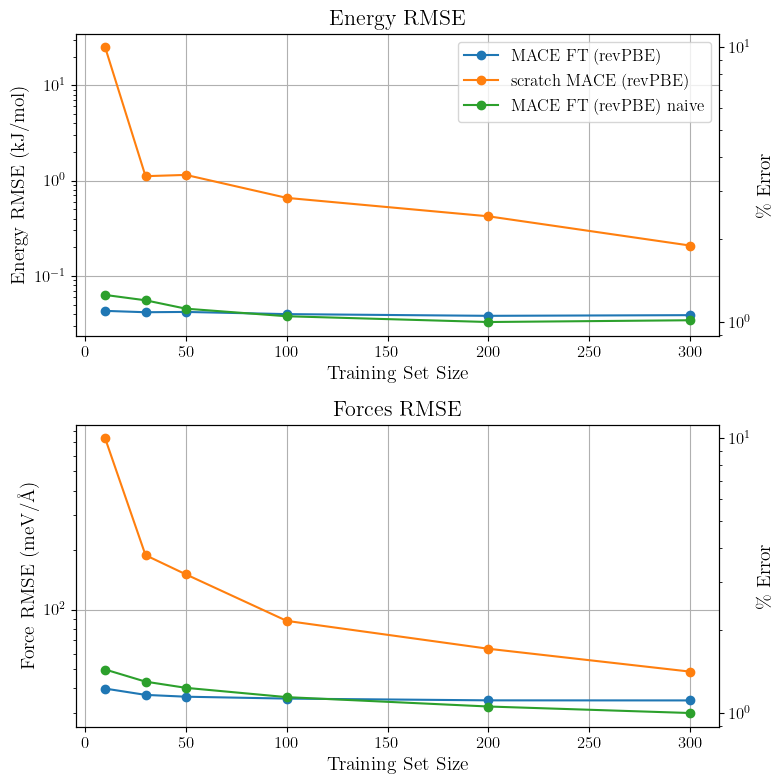

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))



ax1 = axes[0]
ax1.plot(training_set_sizes_medium_revPBE_newE0, np.array(RMSE_energies_medium_revPBE_newE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (revPBE)")
ax1.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_energies_scratch_revPBE_newE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="scratch MACE (revPBE)")
ax1.plot(training_set_sizes_medium_revPBE_naive, np.array(RMSE_energies_medium_revPBE_naive) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (revPBE) naive")

ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")


ax1b = ax1.twinx()
ax1b.set_ylabel(r"$\%$ Error")
ax1b.set_yscale("log") 


ax2 = axes[1]
ax2.plot(training_set_sizes_medium_revPBE_newE0, np.array(RMSE_forces_medium_revPBE_newE0) * 1000, marker="o")
ax2.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_forces_scratch_revPBE_newE0) * 1000, marker="o")
ax2.plot(training_set_sizes_medium_revPBE_naive, np.array(RMSE_forces_medium_revPBE_naive) * 1000, marker="o")

ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)


# Add second y-axis for relative RMSE
ax2b = ax2.twinx()
ax2b.set_ylabel(r"$\%$ Error")
ax2b.set_yscale("log")

plt.tight_layout()
plt.show()

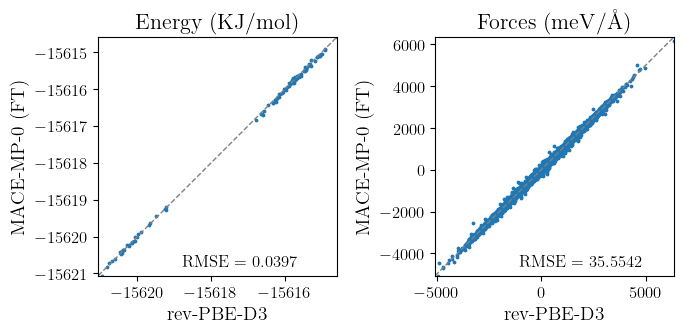

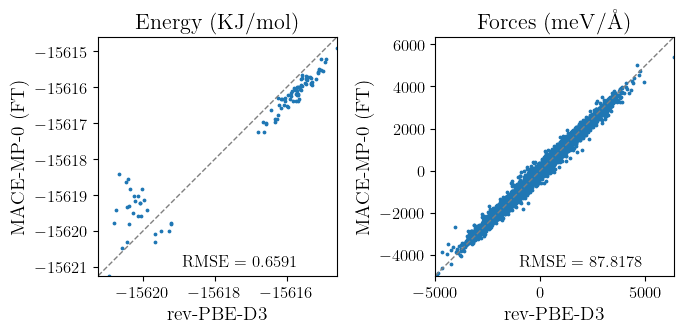

In [62]:
test_data_FT_100 = read("../results/evaluation_data_medium/FT_newE0s_medium_rev_PBE_D3_100_eval_test.xyz", ':')
test_data_scratch_100 = read("../results/evaluation_data_scratch/scratch_newE0s_revPBE_D3_100_eval_test.xyz", ':')

plot_RMSEs(test_data_FT_100, labs=['rev-PBE-D3', 'MACE-MP-0 (FT)'], theory="rPBED3", filepath="correlation_FT_100.png")
plot_RMSEs(test_data_scratch_100, labs=['rev-PBE-D3', 'MACE-MP-0 (FT)'], theory="rPBED3", filepath="correlation_scratch_100.png")

### revPBE0-D3

In [47]:
training_set_sizes_scratch_newE0_revPBE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_newE0_revPBE0 = []
RMSE_forces_scratch_newE0_revPBE0 = []

for size in training_set_sizes_scratch_newE0_revPBE0:
    test_data = read(f"../results/evaluation_scratch_revPBE0/scratch_newE0s_revPBE0_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBE0D3")
    RMSE_energies_scratch_newE0_revPBE0.append(calc[0])
    RMSE_forces_scratch_newE0_revPBE0.append(calc[1])
    
training_set_sizes_FT_newE0_revPBE0 = [10, 30, 50, 100, 200, 300]
RMSE_energies_FT_newE0_revPBE0 = []
RMSE_forces_FT_newE0_revPBE0 = []

for size in training_set_sizes_FT_newE0_revPBE0:
    test_data = read(f"../results/evaluation_FT_revPBE0/FT_newE0s_medium_rev_PBE0_D3_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="rPBE0D3")
    RMSE_energies_FT_newE0_revPBE0.append(calc[0])
    RMSE_forces_FT_newE0_revPBE0.append(calc[1])

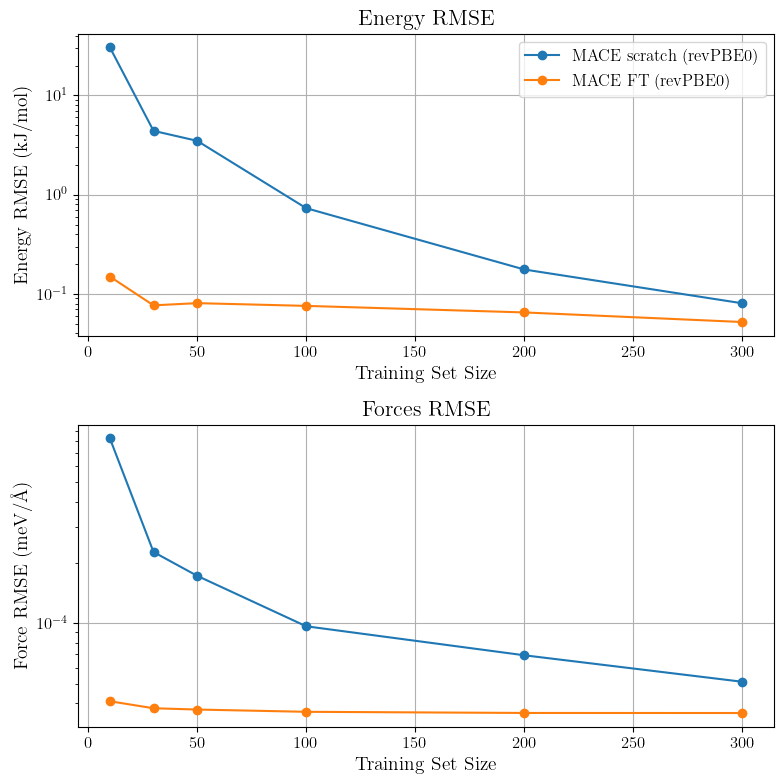

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax1 = axes[0]
ax1.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_energies_scratch_newE0_revPBE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE scratch (revPBE0)")
ax1.plot(training_set_sizes_FT_newE0_revPBE0, np.array(RMSE_energies_FT_newE0_revPBE0) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (revPBE0)")

ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")


ax2 = axes[1]
ax2.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_forces_scratch_newE0_revPBE0) / 1000, marker="o")
ax2.plot(training_set_sizes_FT_newE0_revPBE0, np.array(RMSE_forces_FT_newE0_revPBE0) / 1000, marker="o")

ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)

plt.tight_layout()
plt.show()

### MP2

In [48]:
# FT
training_set_sizes_FT_newE0_MP2 = [10, 30, 50, 100, 200, 300]
RMSE_energies_FT_newE0_MP2 = []
RMSE_forces_FT_newE0_MP2 = []

for size in training_set_sizes_FT_newE0_MP2:
    test_data = read(f"../results/evaluation_FT_MP2/FT_newE0s_medium_MP2_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="MP2")
    RMSE_energies_FT_newE0_MP2.append(calc[0])
    RMSE_forces_FT_newE0_MP2.append(calc[1])

# SCRATCH
training_set_sizes_scratch_newE0_MP2 = [10, 30, 50, 100, 200, 300]
RMSE_energies_scratch_newE0_MP2 = []
RMSE_forces_scratch_newE0_MP2 = []

for size in training_set_sizes_scratch_newE0_MP2:
    test_data = read(f"../results/evaluation_scratch_MP2/scratch_newE0s_MP2_{size}_eval_test.xyz", ':')
    calc = calc_RMSE(test_data, theory="MP2")
    RMSE_energies_scratch_newE0_MP2.append(calc[0])
    RMSE_forces_scratch_newE0_MP2.append(calc[1])

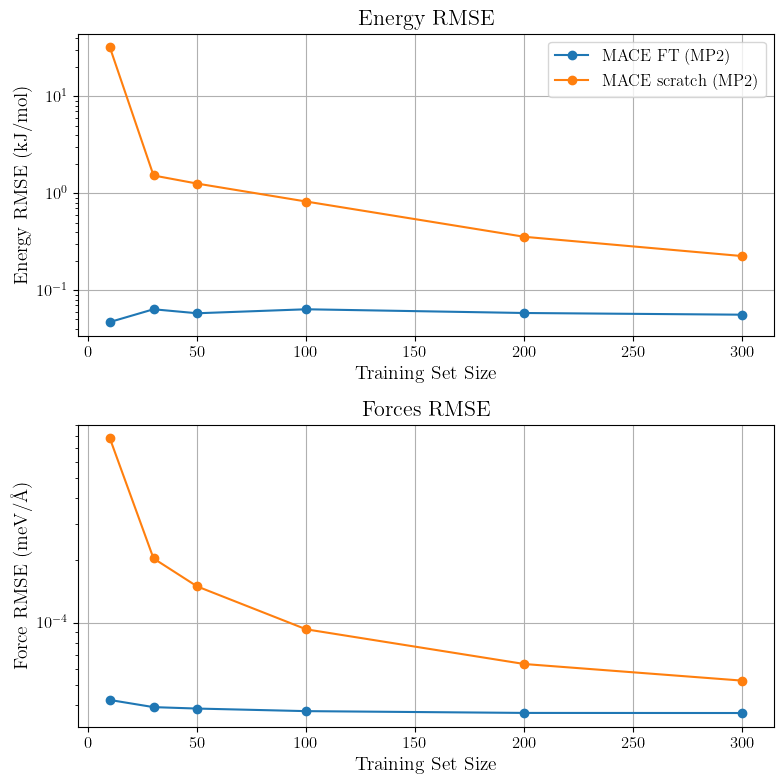

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax1 = axes[0]
ax1.plot(training_set_sizes_FT_newE0_MP2, np.array(RMSE_energies_FT_newE0_MP2) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE FT (MP2)")
ax1.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_energies_scratch_newE0_MP2) * 1.6e-19 * 6.02e23 / 1000, marker="o", label="MACE scratch (MP2)")

ax1.set_ylabel("Energy RMSE (kJ/mol)")
ax1.set_xlabel("Training Set Size")
ax1.set_title("Energy RMSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend(loc="upper right")


ax2 = axes[1]
ax2.plot(training_set_sizes_FT_newE0_MP2, np.array(RMSE_forces_FT_newE0_MP2) / 1000, marker="o")
ax2.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_forces_scratch_newE0_MP2) / 1000, marker="o")
ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$")
ax2.set_xlabel("Training Set Size")
ax2.set_yscale("log")
ax2.set_title("Forces RMSE")
ax2.grid(True)

plt.tight_layout()
plt.show()

### Comparison

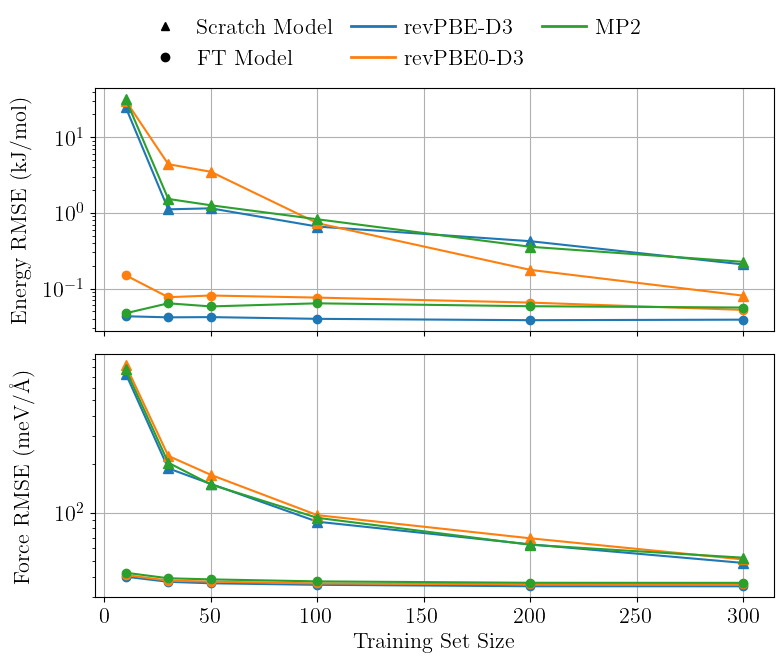

In [57]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Get the default Matplotlib color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Assign colors dynamically
color_map = {
    "revPBE": colors[0],
    "revPBE0": "black",
    "MP2": "red"
}

color_map = {
    "revPBE": "C0",
    "revPBE0": "C1",
    "MP2": "C2"
}

# Energy RMSE Plot
ax1 = axes[0]
ax1.plot(training_set_sizes_medium_revPBE_newE0, np.array(RMSE_energies_medium_revPBE_newE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE"], marker="o", label="revPBE FT")
ax1.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_energies_scratch_revPBE_newE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE"], marker="^", label="revPBE Scratch", markersize=7)

ax1.plot(training_set_sizes_FT_newE0_revPBE0, np.array(RMSE_energies_FT_newE0_revPBE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE0"], marker="o", label="revPBE0 FT")
ax1.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_energies_scratch_newE0_revPBE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE0"], marker="^", label="revPBE0 Scratch", markersize=7)

ax1.plot(training_set_sizes_FT_newE0_MP2, np.array(RMSE_energies_FT_newE0_MP2) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["MP2"], marker="o", label="MP2 FT")
ax1.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_energies_scratch_newE0_MP2) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["MP2"], marker="^", label="MP2 scratch", markersize=7)

ax1.tick_params(axis='both', labelsize=16)
ax1.set_ylabel("Energy RMSE (kJ/mol)", fontsize=16, labelpad=8)
ax1.set_yscale("log")
#ax1.set_title("Energy RMSE")
ax1.grid(True)

# Forces RMSE Plot
ax2 = axes[1]
ax2.plot(training_set_sizes_medium_revPBE_newE0, np.array(RMSE_forces_medium_revPBE_newE0) * 1000, 
         linestyle="-", color=color_map["revPBE"], marker="o")
ax2.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_forces_scratch_revPBE_newE0) * 1000, 
         linestyle="-", color=color_map["revPBE"], marker="^", markersize=7)

ax2.plot(training_set_sizes_FT_newE0_revPBE0, np.array(RMSE_forces_FT_newE0_revPBE0) * 1000, 
         linestyle="-", color=color_map["revPBE0"], marker="o")
ax2.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_forces_scratch_newE0_revPBE0) * 1000, 
         linestyle="-", color=color_map["revPBE0"], marker="^", markersize=7)

ax2.plot(training_set_sizes_FT_newE0_MP2, np.array(RMSE_forces_FT_newE0_MP2) * 1000, 
         linestyle="-", color=color_map["MP2"], marker="o")
ax2.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_forces_scratch_newE0_MP2) * 1000, 
         linestyle="-", color=color_map["MP2"], marker="^", markersize=7)

ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$", fontsize=16, labelpad=15)
ax2.set_xlabel("Training Set Size", fontsize=16)
ax2.set_yscale("log")
#ax2.set_title("Forces RMSE")
ax2.grid(True)
ax2.tick_params(axis='both', labelsize=16)

# Custom Legend with Markers
legend_elements = [
    plt.Line2D([0], [0], linestyle="None", marker="^", color="black", label="Scratch Model"),
    plt.Line2D([0], [0], linestyle="None", marker="o", color="black", label="FT Model"),
    plt.Line2D([0], [0], color=color_map["revPBE"], lw=2, label="revPBE-D3"),
    plt.Line2D([0], [0], color=color_map["revPBE0"], lw=2, label="revPBE0-D3"),
    plt.Line2D([0], [0], color=color_map["MP2"], lw=2, label="MP2"),
]

#fig.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.04), frameon=False)
fig.legend(handles=legend_elements, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.12), frameon=False, handletextpad=0.4, columnspacing=0.8, fontsize=16)

plt.tight_layout()
plt.savefig("../figures/RMSE_scratch_FT.pdf", bbox_inches="tight")
plt.show()



### Multihead

In [51]:
training_set_sizes_scratch_multihead = [10, 30, 50, 100, 200, 300]
heads = ["revPBE_D3", "revPBE0_D3", "MP2"]
RMSE_energies_scratch_multihead = {head: [] for head in heads}
RMSE_forces_scratch_multihead = {head: [] for head in heads}

for size in training_set_sizes_scratch_multihead:
    for head in heads:
        test_data = read(f"../results/evaluation_data_scratch_multihead/scratch_newE0s_multihead_{head}_{size}_eval_test.xyz", ':')
        if head == "revPBE_D3":
            calc = calc_RMSE(test_data, theory="rPBED3")
        elif head == "revPBE0_D3":
            calc = calc_RMSE(test_data, theory="rPBE0D3")
        elif head == "MP2":
            calc = calc_RMSE(test_data, theory="MP2")
        RMSE_energies_scratch_multihead[head].append(calc[0])
        RMSE_forces_scratch_multihead[head].append(calc[1])

In [93]:
heads

['revPBE_D3', 'revPBE0_D3', 'MP2']

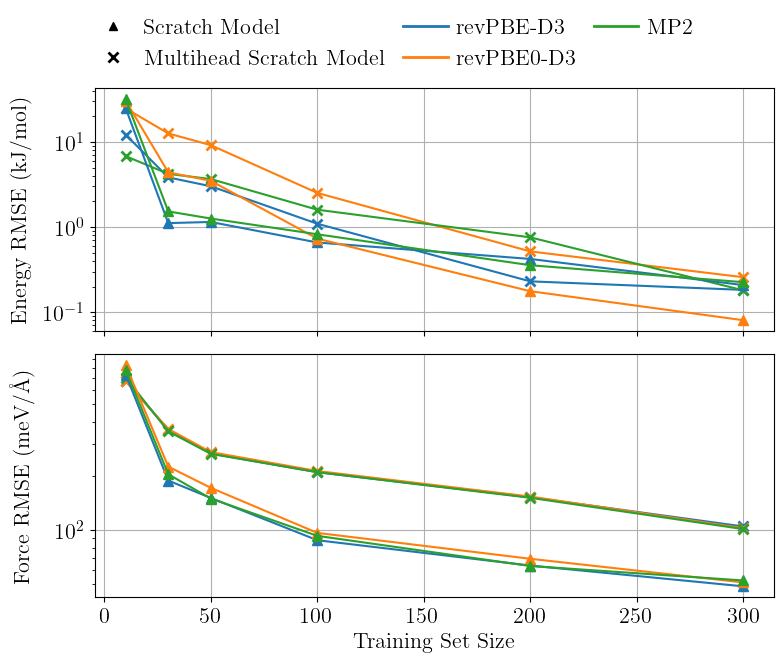

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


color_map = {
    "revPBE_D3": colors[0],
    "revPBE0_D3": "black",
    "MP2": "red"
}

color_map = {
    "revPBE_D3": "C0",
    "revPBE0_D3": "C1",
    "MP2": "C2"
}

ax1 = axes[0]
for head in heads:
    ax1.plot(training_set_sizes_scratch_multihead, np.array(RMSE_energies_scratch_multihead[head]) * 1.6e-19 * 6.02e23 / 1000, marker="x", mew=2, markersize = 7,label=f"MACE scratch ({head})", color=color_map[head])

ax1.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_energies_scratch_revPBE_newE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE_D3"], marker="^", label="revPBE Scratch", markersize=7)
ax1.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_energies_scratch_newE0_revPBE0) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["revPBE0_D3"], marker="^", label="revPBE0 Scratch", markersize=7)
ax1.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_energies_scratch_newE0_MP2) * 1.6e-19 * 6.02e23 / 1000, 
         linestyle="-", color=color_map["MP2"], marker="^", label="MP2 scratch", markersize=7)



ax1.set_ylabel("Energy RMSE (kJ/mol)", fontsize=16, labelpad=8)
ax1.set_yscale("log")
ax1.grid(True)
ax1.tick_params(axis='both', labelsize=16)



ax2 = axes[1]
for head in heads:
    ax2.plot(training_set_sizes_scratch_multihead, np.array(RMSE_forces_scratch_multihead[head]) * 1000, marker="x", mew=2, markersize = 7, color=color_map[head])

ax2.plot(training_set_sizes_scratch_revPBE_newE0, np.array(RMSE_forces_scratch_revPBE_newE0) * 1000, 
         linestyle="-", color=color_map["revPBE_D3"], marker="^", markersize=7)
ax2.plot(training_set_sizes_scratch_newE0_revPBE0, np.array(RMSE_forces_scratch_newE0_revPBE0) * 1000, 
         linestyle="-", color=color_map["revPBE0_D3"], marker="^", markersize=7)
ax2.plot(training_set_sizes_scratch_newE0_MP2, np.array(RMSE_forces_scratch_newE0_MP2) * 1000, 
         linestyle="-", color=color_map["MP2"], marker="^", markersize=7)


ax2.set_ylabel(r"Force RMSE $\rm (meV/\AA)$", fontsize=16, labelpad=15)
ax2.set_xlabel("Training Set Size", fontsize=16)
ax2.set_yscale("log")
ax2.grid(True)
ax2.tick_params(axis='both', labelsize=16)


legend_elements = [
    plt.Line2D([0], [0], linestyle="None", marker="^", color="black", label="Scratch Model"),
    plt.Line2D([0], [0], linestyle="None", marker="x",markersize=7, mew=2, color="black", label="Multihead Scratch Model"),
    plt.Line2D([0], [0], color=color_map["revPBE_D3"], lw=2, label="revPBE-D3"),
    plt.Line2D([0], [0], color=color_map["revPBE0_D3"], lw=2, label="revPBE0-D3"),
    plt.Line2D([0], [0], color=color_map["MP2"], lw=2, label="MP2"),
]

#fig.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.04), frameon=False, handletextpad=0.4, columnspacing=0.8, fontsize=14)
fig.legend(handles=legend_elements, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.12), frameon=False, handletextpad=0.4, columnspacing=0.8, fontsize=16)


plt.tight_layout()
plt.savefig("../figures/RMSE_scratch_multihead.pdf",  bbox_inches="tight")
plt.show()